# INF-0616 - Aula 4: classificação de reviews de filmes do IMDB
O exemplo abaixo foi adaptado de fchollet/deep-learning-with-python-notebooks/.../3.5-classifying-movie-reviews.

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- alana.correia@ic.unicamp.br


Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina: 
[moodle.lab.ic.unicamp.br/469](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=469)

Instituto de Computação - Unicamp 2022



In [ ]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn import datasets
from sklearn.model_selection import train_test_split

from keras import callbacks
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

np.random.seed(42)
sns.set()

def readIMDBData():
    #Just a gimmick to be able to read imdb data with this version of numpy
    ### ============
    np_load_old = np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
    np.load = np_load_old
    
    return (x_train, y_train), (x_test, y_test)

## Determinando sentimento (positivo ou negativo) em *reviews* no **IMDB**
### Lendo o conjunto de dados

**IMDB** é um conjunto contendo reviews textuais previamente processadas e rótulos de sentimento (positivo ou negativo) associados à cada review.

O conjunto é internalizado no keras e pode ser lido da seguinte forma:

In [ ]:
from keras.datasets import imdb

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

labels = 'negative positive'.split()

print(x_train.shape, x_test.shape)

17465344/17464789 [==============================] - 0s 0us/step
(25000,) (25000,)


#### 2 primeiras amostras no conjunto de treinamento

Cada palavra foi codificada por um inteiro identificador. Um documento é então representado por um vetor de inteiros.

In [ ]:
print(*x_train[:2], sep='\n\n')

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]

[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 

Podemos decodificar as mensagens em palavras olhando para o mapa inverso:

In [ ]:
_words = imdb.get_word_index()
_rwords = {wo: ix for ix, wo in _words.items()}

def decode_review(review):
    # Indexamos a partir do 3 pois 0, 1 and 2 sao reservados para "padding",
    # "start of sequence", and "unknown".
    return ' '.join([_rwords.get(i - 3, '?') for i in review])

print(*(decode_review(r) for r in x_train[:2]), sep='\n\n')

1646592/1641221 [==============================] - 0s 0us/step
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amaz

E podemos ver também o rótulo destas duas amostas:

In [ ]:
print([labels[y] for y in y_train[:2]])

['positive', 'negative']


### Preprocessamento

Muito pre-processamento já foi feito sobre o conjunto, como eliminação de artigos, preposições e `stop-words`. Precisamos agora vetorizar os vetores de reviews para eliminar a enumeração natural dos inteiros, de forma similar como ocorre com o vetor de classes, para casos multi-classe, onde aplicamos o *one-hot encoding*:

In [ ]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

x_train = vectorize_sequences(x_train)
x_test = vectorize_sequences(x_test)

y_train = y_train.astype(float)
y_test = y_test.astype(float)

### Visualizando frequências das classes no conjunto

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


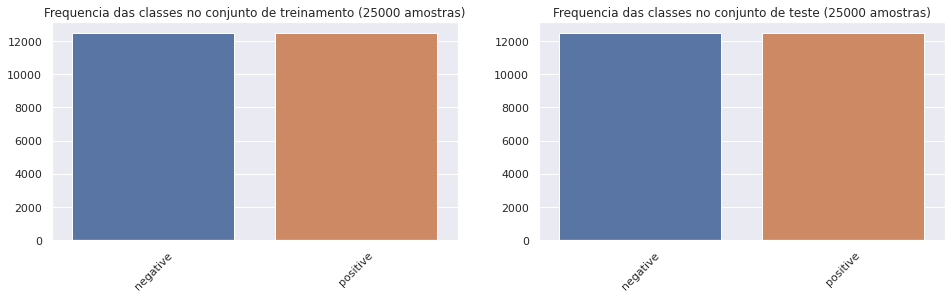

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % x_train.shape[0])
_, counts = np.unique(y_train, return_counts=True)
sns.barplot(labels, counts)
plt.xticks(rotation=45)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % x_test.shape[0])
_, counts = np.unique(y_test, return_counts=True)
sns.barplot(labels, counts)
plt.xticks(rotation=45);

### Definindo um determinador de sentimento

Descreva as camadas da rede de detecção de sentimento.  
Compile o modelo utilizando o otimizador `SGD` e a função de perda `binary_crossentropy`.

In [ ]:
from keras import Sequential
from keras.layers import InputLayer, Dense

model = Sequential([
    InputLayer((10000,)),
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

Existe uma outra forma de definir modelos no Keras, utilizando a API funcional:

```
from keras import Input, Model

x = Input(shape=[1000])
y = Dense(...)(x)
y = Dense(...)(y)
model = Model(inputs=x, outputs=y)
model.compile(...)
```

Você deve conseguir ver um sumário do seu modelo, se a definição acima foi feita corretamente:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               5120512   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 5,252,097
Trainable params: 5,252,097
Non-trainable params: 0
_________________________________________________________________


### Treinando o modelo

Treine o modelo definido acima sobre o conjunto.

In [ ]:
device = '/cpu:0'  # ou '/gpu:0'

epochs = 10 # ou 20, 30, 60, 70...
batch_size = 512 # ou 128, 256, 1024, 2048...
validation_split = .3

with tf.device(device):
    model.fit(x_train, y_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_split=validation_split,
              verbose=1,
              callbacks=[
                  callbacks.TerminateOnNaN(),
                  callbacks.ModelCheckpoint('networks-2-best-weights.h5',
                                            save_best_only=True,
                                            verbose=1),
              ])

Epoch 1/10
35/35 [==============================] - ETA: 0s - loss: 0.6981 - binary_accuracy: 0.5058
Epoch 00001: val_loss improved from inf to 0.69174, saving model to networks-2-best-weights.h5
35/35 [==============================] - 11s 309ms/step - loss: 0.6981 - binary_accuracy: 0.5058 - val_loss: 0.6917 - val_binary_accuracy: 0.5211
Epoch 2/10
35/35 [==============================] - ETA: 0s - loss: 0.6879 - binary_accuracy: 0.5575
Epoch 00002: val_loss improved from 0.69174 to 0.68424, saving model to networks-2-best-weights.h5
35/35 [==============================] - 11s 301ms/step - loss: 0.6879 - binary_accuracy: 0.5575 - val_loss: 0.6842 - val_binary_accuracy: 0.5935
Epoch 3/10
35/35 [==============================] - ETA: 0s - loss: 0.6812 - binary_accuracy: 0.6138
Epoch 00003: val_loss improved from 0.68424 to 0.67792, saving model to networks-2-best-weights.h5
35/35 [==============================] - 11s 303ms/step - loss: 0.6812 - binary_accuracy: 0.6138 - val_loss: 0.6

Podemos exibir o histórico do treinamento do modelo acessando `model.history`:

In [ ]:
history_f = pd.DataFrame(model.history.history)
history_f.head()

,val_loss,val_binary_accuracy,loss,binary_accuracy
0,0.688362,0.551600,0.692524,0.516571
1,0.682084,0.599333,0.685895,0.574114
2,0.675248,0.647333,0.678989,0.627714
3,0.667351,0.685200,0.671287,0.673886
4,0.657927,0.714133,0.662406,0.708571


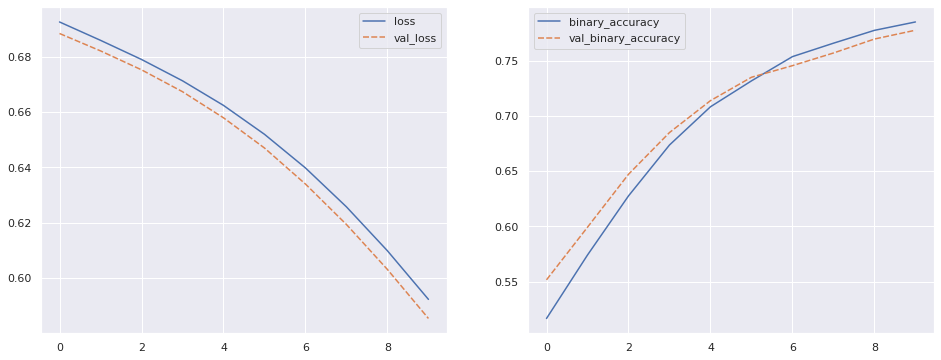

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history_f.loc[:10, ['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history_f.loc[:30, ['binary_accuracy', 'val_binary_accuracy']]);

### Avaliando o modelo treinado

Podemos re-utilizar as ferramentas do scikit-learn que aprendemos até agora para avaliar o modelo:

In [ ]:
model.load_weights('networks-2-best-weights.h5')

from sklearn import metrics

probabilities = model.predict(x_test)
predictions = (probabilities > .5).astype(float)

print(metrics.classification_report(y_test.ravel(), predictions.ravel()))

              precision    recall  f1-score   support

         0.0       0.79      0.76      0.77     12500
         1.0       0.77      0.79      0.78     12500

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78     25000



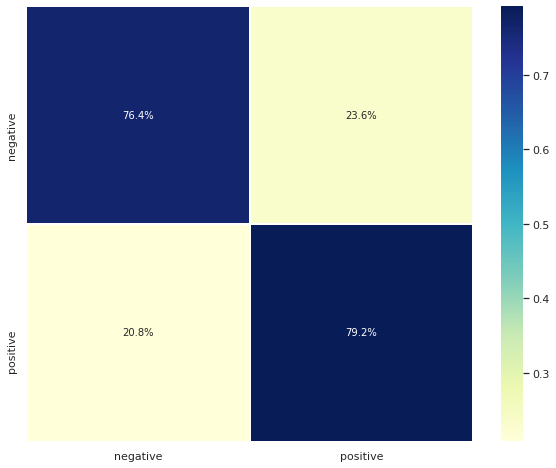

In [ ]:
c = metrics.confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1).reshape(-1, 1)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%', xticklabels=labels, yticklabels=labels);